In [1]:
pip install asyncpg

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import asyncio
import asyncpg

# Функция для подключения к базе данных
async def connect_to_db():
    connection = await asyncpg.connect(
        user='postgres',
        password='Pdjyjr2',
        database='SoldAnalysis',
        host='localhost',
        port='5432'
    )
    return connection


In [3]:
import pandas as pd
# Функция для получения данных
async def fetch_data():
    connection = await connect_to_db()
    query = "SELECT * FROM public.sold_usernames ORDER BY price DESC"
    records = await connection.fetch(query)
    await connection.close()  # Закрываем соединение
    return records

# Используем await напрямую в Jupyter Notebook
data = await fetch_data()

# Преобразуем данные в DataFrame
df = pd.DataFrame(data, columns=['id', 'username', 'price', 'sale_date'])

# Преобразуем sale_date в datetime
df['sale_date'] = pd.to_datetime(df['sale_date'])

# Извлекаем дату (без времени)
df['sale_day'] = df['sale_date'].dt.date

# Преобразуем все значения в строки (на всякий случай)
df['price'] = df['price'].astype(str)

# Очищаем данные: удаляем всё, кроме цифр, точек и запятых
df['price'] = df['price'].str.replace(r'[^0-9.,]', '', regex=True)

# Преобразуем в числа: заменяем запятые на пустую строку и преобразуем в float
df['price'] = pd.to_numeric(df['price'].str.replace(',', ''), errors='coerce')

# Удаляем строки с NaN в price
df.dropna(subset=['price'], inplace=True)

# Проверяем тип данных столбца price после преобразования
print("Тип данных столбца price после преобразования:", df['price'].dtype)

# Теперь можно фильтровать данные по дням
df_0309 = df[df['sale_day'] == pd.to_datetime('2025-03-09').date()]
df_0310 = df[df['sale_day'] == pd.to_datetime('2025-03-10').date()]
df_0311 = df[df['sale_day'] == pd.to_datetime('2025-03-11').date()]

# Выводим результат
print("Данные за 2025-03-09:")
print(df_0309.head())

print("Данные за 2025-03-10:")
print(df_0311.head())

Тип данных столбца price после преобразования: float64
Данные за 2025-03-09:
     id      username    price           sale_date    sale_day
0   424      @chatgpt  80000.0 2025-03-09 20:36:48  2025-03-09
1   431         @tgai  13650.0 2025-03-09 20:21:53  2025-03-09
68  433    @buterbrod    400.0 2025-03-09 20:14:18  2025-03-09
80  469     @godofwar    222.0 2025-03-09 18:13:36  2025-03-09
85  414  @anthologist    200.0 2025-03-09 22:26:01  2025-03-09
Данные за 2025-03-10:
      id username   price           sale_date    sale_day
2   2193    @duba  8400.0 2025-03-11 11:31:55  2025-03-11
3   2109    @pg88  5303.0 2025-03-11 04:05:58  2025-03-11
8   2106    @ag88  5050.0 2025-03-11 04:11:44  2025-03-11
10  2620    @yldb  5050.0 2025-03-11 15:16:41  2025-03-11
12  2521    @loud  5050.0 2025-03-11 18:12:55  2025-03-11


In [4]:
# Общее количество продаж за 2025-03-09
total_sales_0309 = df_0309.shape[0]
print(f"Общее количество продаж за 2025-03-09: {total_sales_0309}")

# Общее количество продаж за 2025-03-10
total_sales_0310 = df_0310.shape[0]
print(f"Общее количество продаж за 2025-03-10: {total_sales_0310}")

# Общее количество продаж за 2025-03-11
total_sales_0311 = df_0311.shape[0]
print(f"Общее количество продаж за 2025-03-11: {total_sales_0311}")

Общее количество продаж за 2025-03-09: 98
Общее количество продаж за 2025-03-10: 430
Общее количество продаж за 2025-03-11: 558


In [5]:
# Топ-10 самых дорогих продаж
#top_20_expensive = df_0310.nlargest(20, 'price')
top_20_expensive = df.nlargest(20, 'price')
#print("Топ-20 самых дорогих продаж за 10 марта:")
print("Топ-20 самых дорогих продаж за весь период наблюдений:")
print(top_20_expensive[['username', 'price', 'sale_date']])

Топ-20 самых дорогих продаж за весь период наблюдений:
              username    price           sale_date
0             @chatgpt  80000.0 2025-03-09 20:36:48
1                @tgai  13650.0 2025-03-09 20:21:53
2                @duba   8400.0 2025-03-11 11:31:55
3                @pg88   5303.0 2025-03-11 04:05:58
4                @jdtc   5050.0 2025-03-10 12:05:14
5                @kuku   5050.0 2025-03-10 12:07:15
6                @jpay   5050.0 2025-03-10 12:12:08
7                @sfgq   5050.0 2025-03-10 20:00:51
8                @ag88   5050.0 2025-03-11 04:11:44
9                @cgdb   5050.0 2025-03-10 07:35:37
10               @yldb   5050.0 2025-03-11 15:16:41
11               @csjr   5050.0 2025-03-10 10:25:15
12               @loud   5050.0 2025-03-11 18:12:55
13               @pork   5050.0 2025-03-11 03:25:55
14               @gmgn   5050.0 2025-03-11 03:17:54
15               @diss   5050.0 2025-03-12 05:27:40
16            @android   4023.0 2025-03-12 13:03:11
17  @sato

In [8]:
# Средняя цена
average_price = df_0310['price'].mean()

# Медианная цена
median_price = df_0310['price'].median()

print(f"Средняя цена продаж за 10 марта: {average_price}")
print(f"Медианная цена продаж за 10 марта: {median_price}")

# Средняя цена
average_price = df_0311['price'].mean()

# Медианная цена
median_price = df_0311['price'].median()

print(f"Средняя цена продаж за 11 марта: {average_price}")
print(f"Медианная цена продаж за 11 марта: {median_price}")

Средняя цена продаж за 10 марта: 99.90172093023257
Медианная цена продаж за 10 марта: 10.0
Средняя цена продаж за 11 марта: 296.9621863799283
Медианная цена продаж за 11 марта: 10.0


In [9]:
# Количество продаж по часам
df_0310['sale_hour'] = df_0310['sale_date'].dt.hour
sales_per_hour = df_0310.groupby('sale_hour').size().reset_index(name='количество_продаж')
print(sales_per_hour)

    sale_hour  количество_продаж
0           0                  5
1           1                  8
2           2                  6
3           3                  6
4           4                  6
5           5                  7
6           6                 23
7           7                 15
8           8                 12
9           9                 25
10         10                 19
11         11                 16
12         12                 26
13         13                 27
14         14                 18
15         15                 22
16         16                 18
17         17                 26
18         18                 21
19         19                 24
20         20                 20
21         21                 30
22         22                 30
23         23                 20


C:\Users\IG\AppData\Local\Temp\ipykernel_16552\3456829741.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_0310['sale_hour'] = df_0310['sale_date'].dt.hour


In [10]:
pip install matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


C:\Users\IG\AppData\Local\Temp\ipykernel_16552\2818137398.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sales_per_hour, x='sale_hour', y='количество_продаж', palette="viridis")


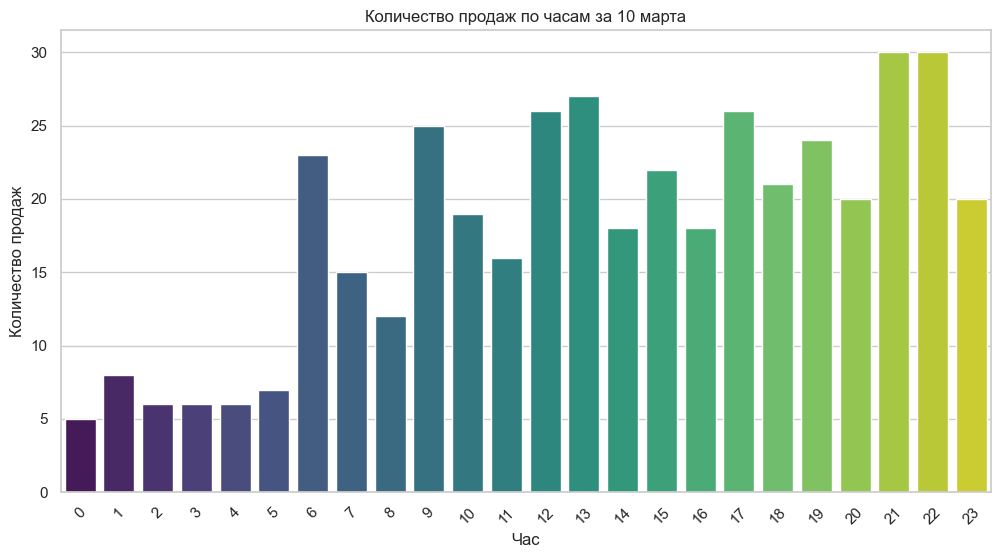

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля
sns.set(style="whitegrid")

# Создаем график
plt.figure(figsize=(12, 6))
sns.barplot(data=sales_per_hour, x='sale_hour', y='количество_продаж', palette="viridis")
plt.title('Количество продаж по часам за 10 марта')
plt.xlabel('Час')
plt.ylabel('Количество продаж')
plt.xticks(rotation=45)
plt.show()

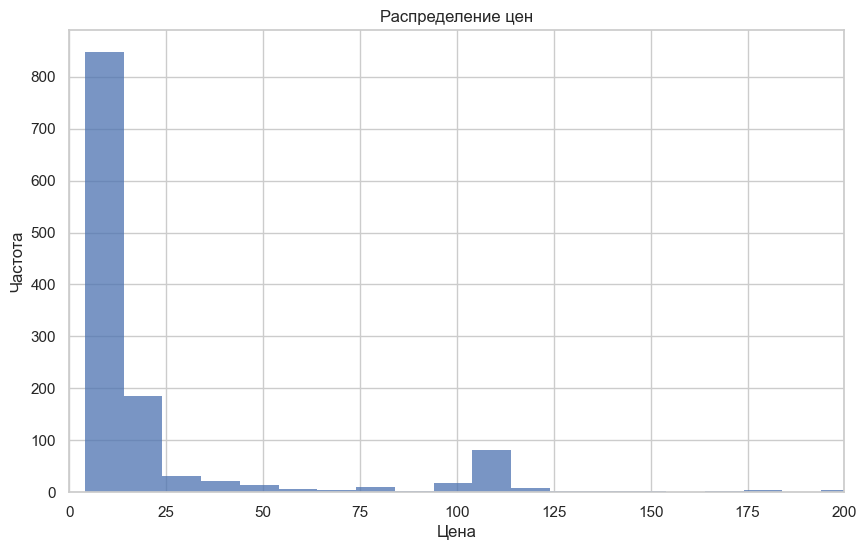

In [12]:
# Гистограмма цен
plt.figure(figsize=(10, 6))

# Строим гистограмму с шириной столбцов 10
sns.histplot(df['price'], binwidth=10, kde=False)
plt.title('Распределение цен')
plt.xlim(0,200)

# Включаем сетку
plt.grid(True)

plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()